In [53]:
import os
import cv2
import imghdr
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from pathlib import Path
import pandas as pd
from sklearn.model_selection import train_test_split

# Cleaning Images

In [3]:
data_dir = 'Images/'

In [4]:
image_extensions = ['jpg', 'jpeg', 'png', 'bmp']

In [ ]:
for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            image_type = imghdr.what(image_path)
            if image_type not in image_extensions:
                print(f'{image_path} is not a valid image')
                os.remove(image_path)
        except Exception as e:
            print(f'Error processing {image_path}: {e}')

# Data Preprocessing

In [20]:
data = tf.keras.utils.image_dataset_from_directory(data_dir)

Found 16609 files belonging to 14 classes.


In [37]:
data_iterators = data.as_numpy_iterator()
batch = next(data_iterators)
batch[1].max()


np.int32(13)

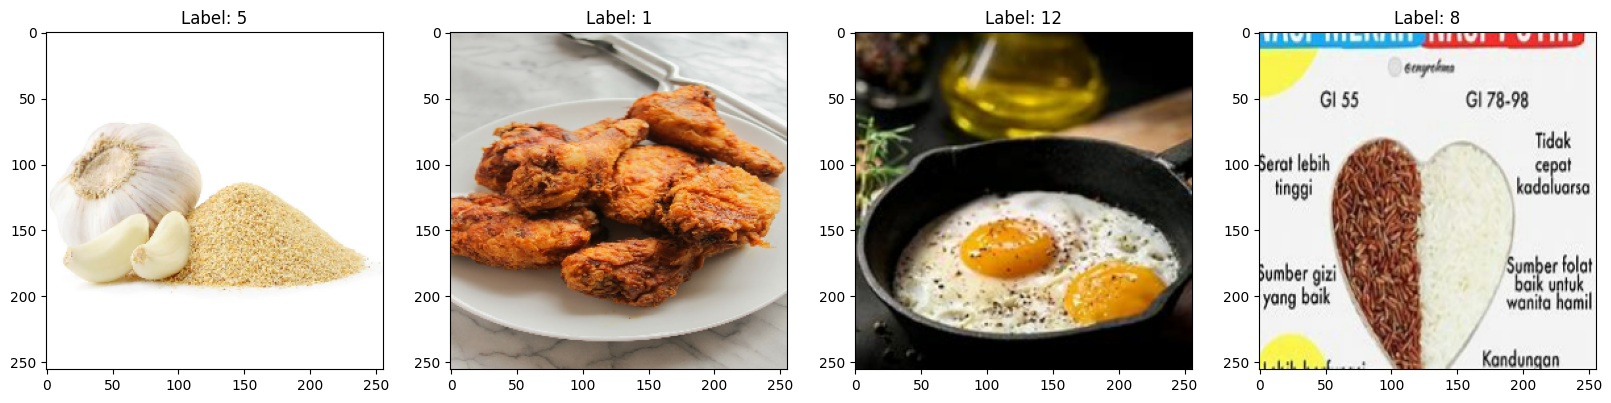

In [36]:
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx, image in enumerate(batch[0][:4]):
    ax[idx].imshow(image.astype(int))
    ax[idx].title.set_text(f'Label: {batch[1][idx]}')

In [50]:
data_dir_path = Path(data_dir)
filepaths = list(data_dir_path.glob(r'**/*.jpg'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

images = pd.concat([filepaths, labels], axis=1)

category_samples = []
for category in images['Label'].unique():
    category_slice = images.query("Label == @category")
    category_samples.append(category_slice.sample(400, random_state=1))
image_df = pd.concat(category_samples, axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)

In [51]:
image_df['Label'].value_counts()

Label
Tahu Goreng        400
Tempe Goreng       400
Alpukat            400
Bawang Merah       400
Cabe Rawit         400
Bakso              400
Ayam Goreng        400
Bawang Bombai      400
Sate Ayam          400
Bawang Putih       400
Nasi Putih         400
Mangga             400
Pisang             400
Telur Mata Sapi    400
Name: count, dtype: int64

Split Data

In [54]:
train_df, test_df = train_test_split(
    image_df, 
    train_size=0.7, 
    shuffle=True, 
    random_state=1)

In [56]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [ ]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)